# Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
#pip install keras

# Data Preprocessing

In [3]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=128,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True,

)

Found 70295 files belonging to 38 classes.


In [4]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,

)

Found 17572 files belonging to 38 classes.


In [5]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

# Building Model

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

## MobileNet Model

In [7]:
import h5py
print(h5py.__version__)

3.10.0


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

### Fine-Tuning

In [9]:
# Add custom classification layers on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)  # Add dropout to reduce overfitting
x = Dense(38, activation='softmax')(x)  # Adjust the output size based on your task

In [10]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block_14_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,080 (5.82 MB)

 Non-trainable params: 731,904 (2.79 MB)

### Add custom classifcation layer

In [12]:
# # Normalize
# def process(image,label):
#     image = tf.cast(image/255. ,tf.float32)
#     return image,label

# train_ds = training_set.map(process)
# validation_ds = validation_set.map(process)

In [13]:
# Create the fine-tuned model
from tensorflow.keras.optimizers import SGD

modelMobileNet = Model(inputs=base_model.input, outputs=x)
optimizer_SGD = SGD(learning_rate=1e-4, momentum=0.9)

# Compile the model
modelMobileNet.compile(
    
    optimizer=optimizer_SGD,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Normalize the data
def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

In [15]:
modelMobileNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 7,510,886 (28.65 MB)

 Trainable params: 6,778,982 (25.86 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [16]:
history_mobilenet = modelMobileNet.fit(training_set,epochs=10,validation_data=validation_set)

Epoch 1/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.1901 - loss: 3.3142 - val_accuracy: 0.1398 - val_loss: 3.4106
Epoch 2/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - accuracy: 0.5326 - loss: 1.6597 - val_accuracy: 0.3112 - val_loss: 2.5328
Epoch 3/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - accuracy: 0.6428 - loss: 1.2285 - val_accuracy: 0.4955 - val_loss: 1.7448
Epoch 4/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.7064 - loss: 0.9946 - val_accuracy: 0.6492 - val_loss: 1.1925
Epoch 5/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.7479 - loss: 0.8354 - val_accuracy: 0.7262 - val_loss: 0.9349
Epoch 6/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.7785 - loss: 0.7283 - val_accuracy: 0.7550 - val_loss: 0.8202
Epoch 7/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - accuracy: 0.8052 - loss: 0.6410 - val_accuracy: 0.7737 - val_loss: 0.7522
Epoch 8/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - accuracy: 0.8262 - loss: 0.5670 - val_accu

In [17]:
#Training set Accuracy
train_loss, train_acc = modelMobileNet.evaluate(training_set)
print('Training accuracy:', train_acc)

550/550 ━━━━━━━━━━━━━━━━━━━━ 438s 788ms/step - accuracy: 0.9267 - loss: 0.2807
Training accuracy: 0.9304075837135315


In [18]:
#Validation set Accuracy
val_loss, val_acc = modelMobileNet.evaluate(validation_set)
print('Validation accuracy:', val_acc)

550/550 ━━━━━━━━━━━━━━━━━━━━ 127s 230ms/step - accuracy: 0.8127 - loss: 0.6213
Validation accuracy: 0.8028112649917603


In [19]:
modelMobileNet.save('modelMobileNet_SGD.keras')

In [20]:
history_mobilenet.history #Return Dictionary of history

{'accuracy': [0.31492993235588074,
  0.5640941858291626,
  0.6601465344429016,
  0.7173056602478027,
  0.755231499671936,
  0.7851625084877014,
  0.8087630867958069,
  0.828721821308136,
  0.8454939723014832,
  0.8607297539710999],
 'loss': [2.6320548057556152,
  1.5323708057403564,
  1.166908621788025,
  0.9560112953186035,
  0.8132302165031433,
  0.7061304450035095,
  0.6252263188362122,
  0.5573683977127075,
  0.49880853295326233,
  0.45067670941352844],
 'val_accuracy': [0.1397678107023239,
  0.311233788728714,
  0.4955042004585266,
  0.6491577625274658,
  0.7261552214622498,
  0.7550079822540283,
  0.7736740112304688,
  0.7867630124092102,
  0.7945026159286499,
  0.8028112649917603],
 'val_loss': [3.4105777740478516,
  2.532848834991455,
  1.7448337078094482,
  1.1925067901611328,
  0.9348927736282349,
  0.8201677203178406,
  0.7521642446517944,
  0.7085313200950623,
  0.6775604486465454,
  0.6513925790786743]}

In [21]:
#Recording History in json
import json
with open('training_hist_MobileNet.json','w') as f:
  json.dump(history_mobilenet.history,f)


In [22]:
print(history_mobilenet.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Loading Model

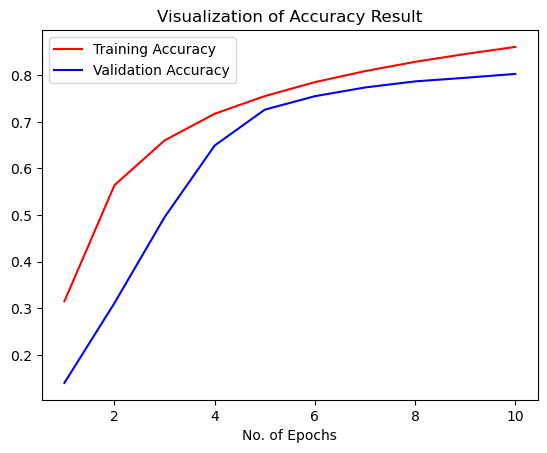

In [25]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,history_mobilenet.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history_mobilenet.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()


## Some other metrics to evaluate our Model

In [26]:
class_name = validation_set.class_names

In [27]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


In [28]:
y_pred = modelMobileNet.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 523s 30ms/step


In [29]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [30]:
Y_true

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [31]:
predicted_categories

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [32]:
import sklearn.metrics

from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)

In [33]:
# Precision Recall Fscore
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.67      0.66      0.67       504
                                 Apple___Black_rot       0.89      0.84      0.86       497
                          Apple___Cedar_apple_rust       0.83      0.81      0.82       440
                                   Apple___healthy       0.71      0.73      0.72       502
                               Blueberry___healthy       0.81      0.82      0.82       454
          Cherry_(including_sour)___Powdery_mildew       0.85      0.80      0.83       421
                 Cherry_(including_sour)___healthy       0.87      0.91      0.89       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.77      0.78       410
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.79      0.91      0.

## Conflict Matrix Visualization

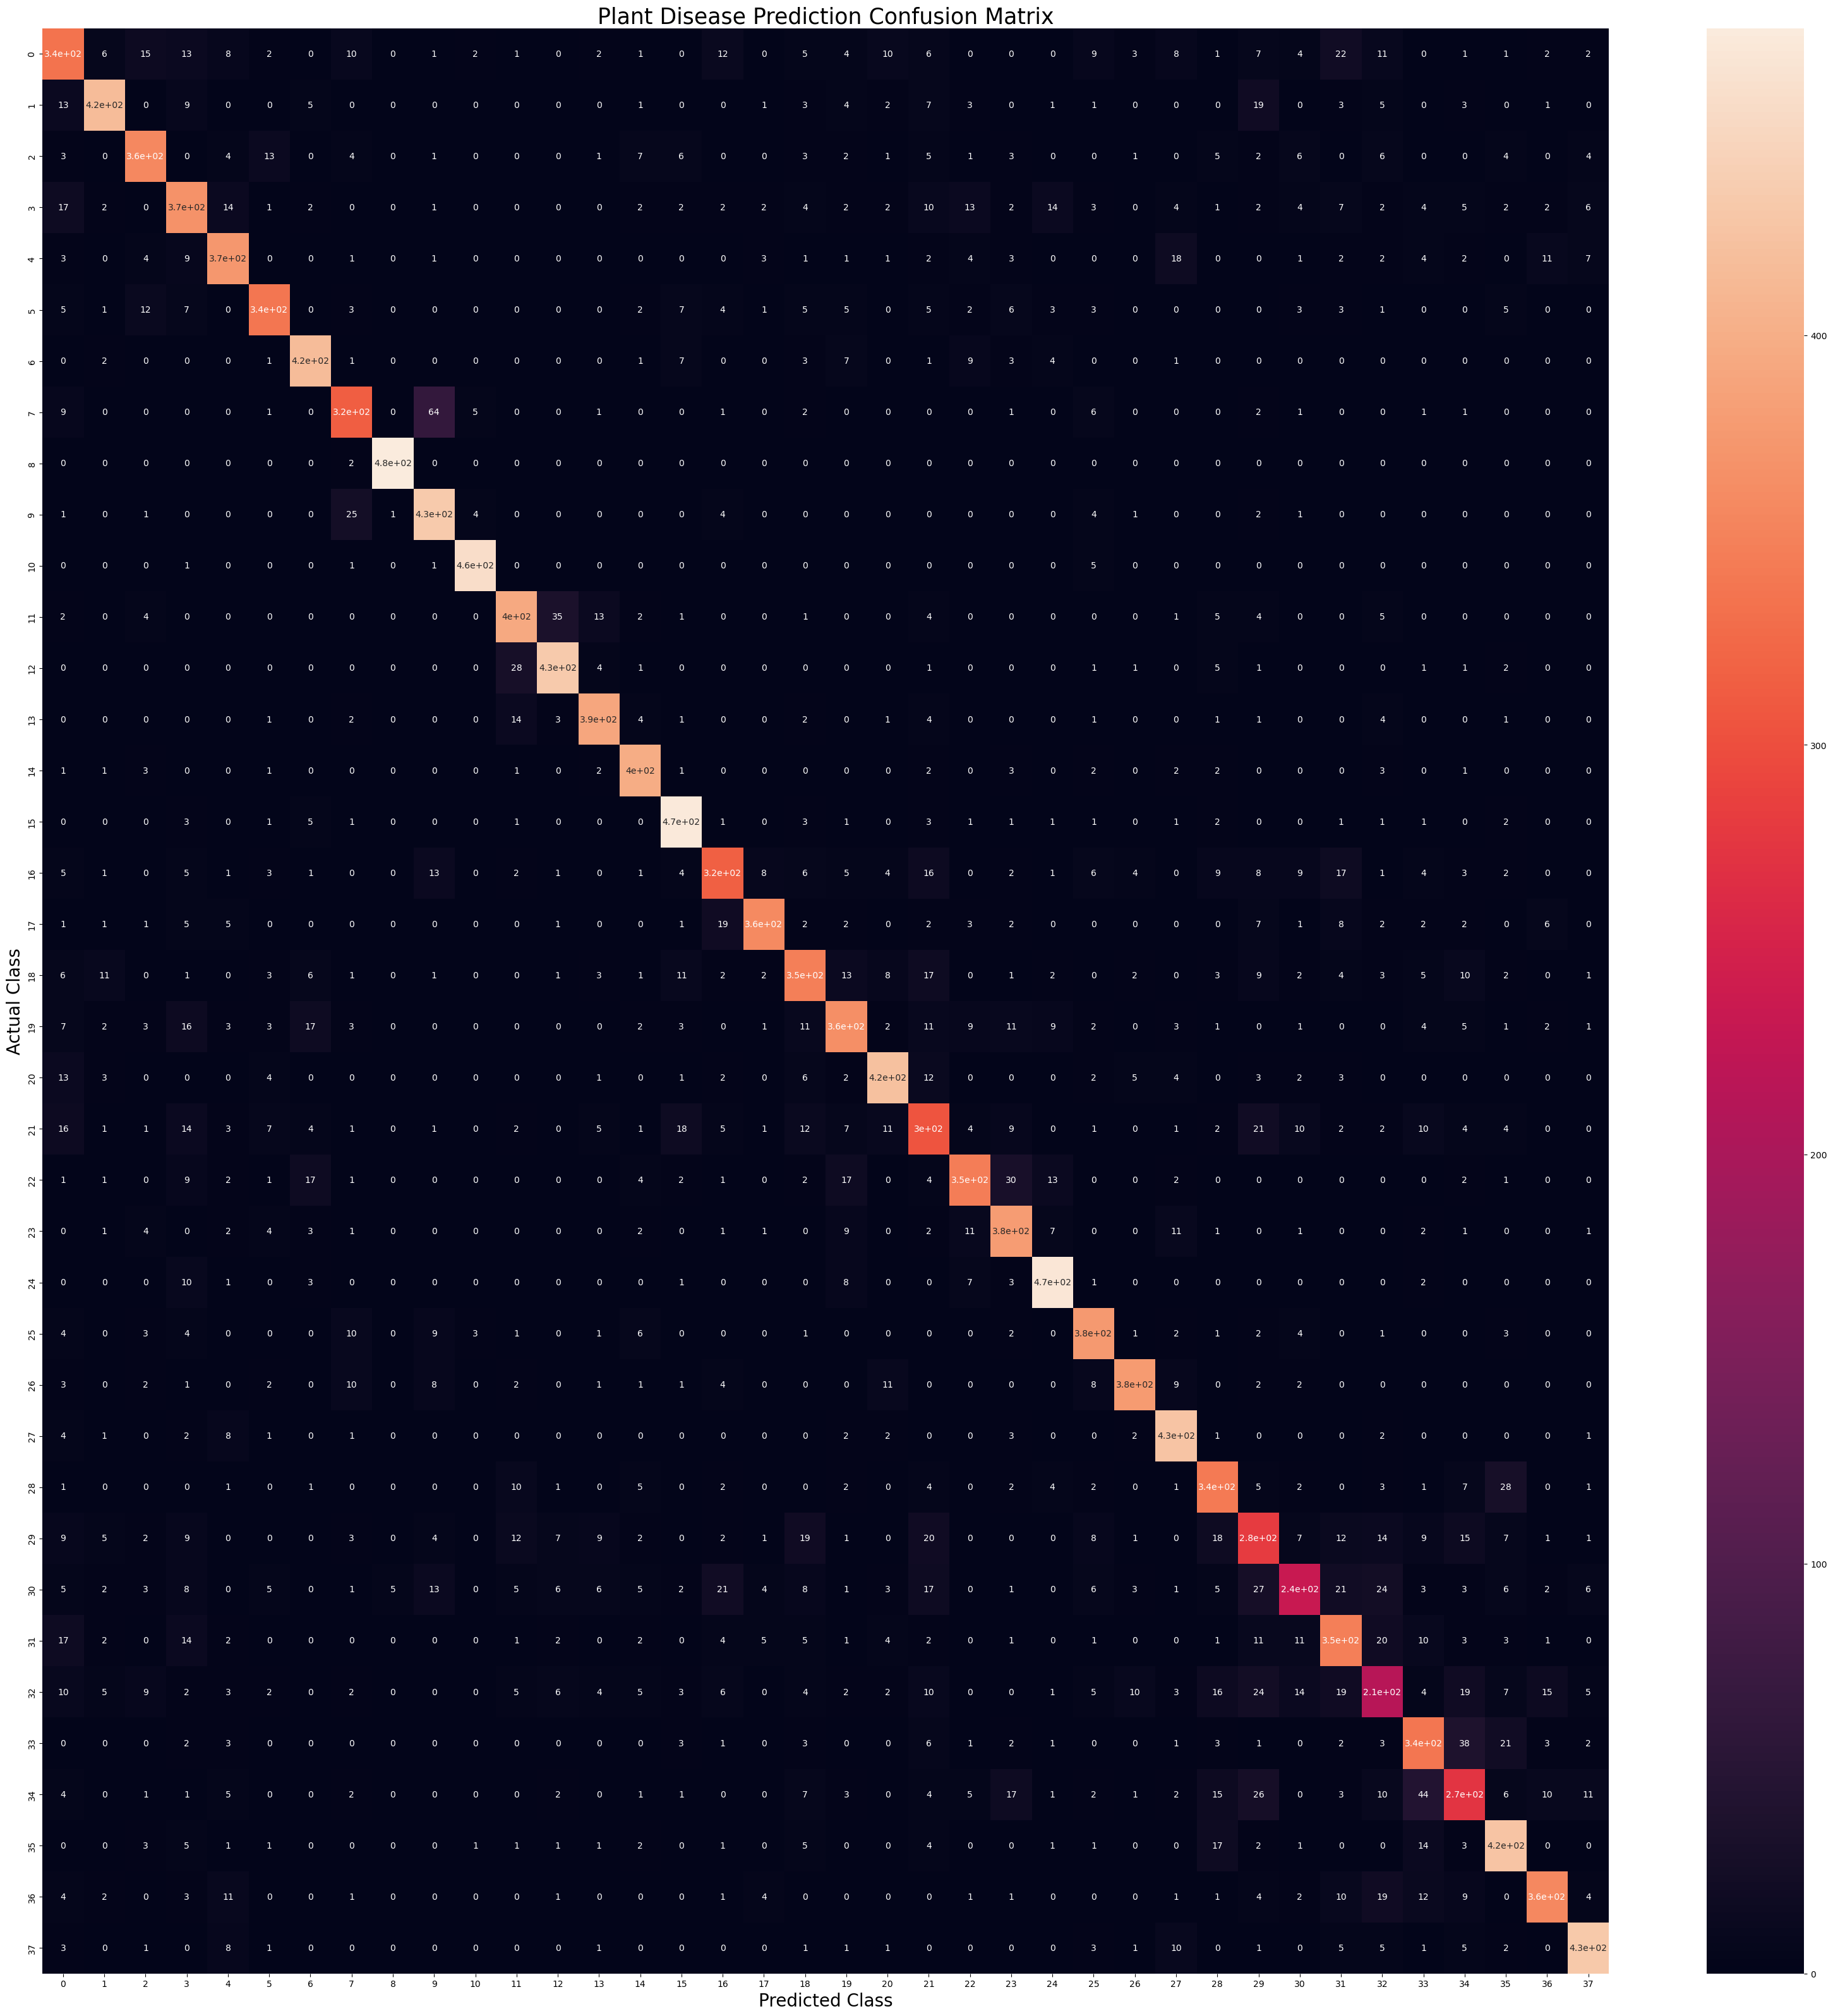

In [34]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()